<a href="https://colab.research.google.com/github/gitorivera/sneia-lectures/blob/main/Convolutional_cats_n_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

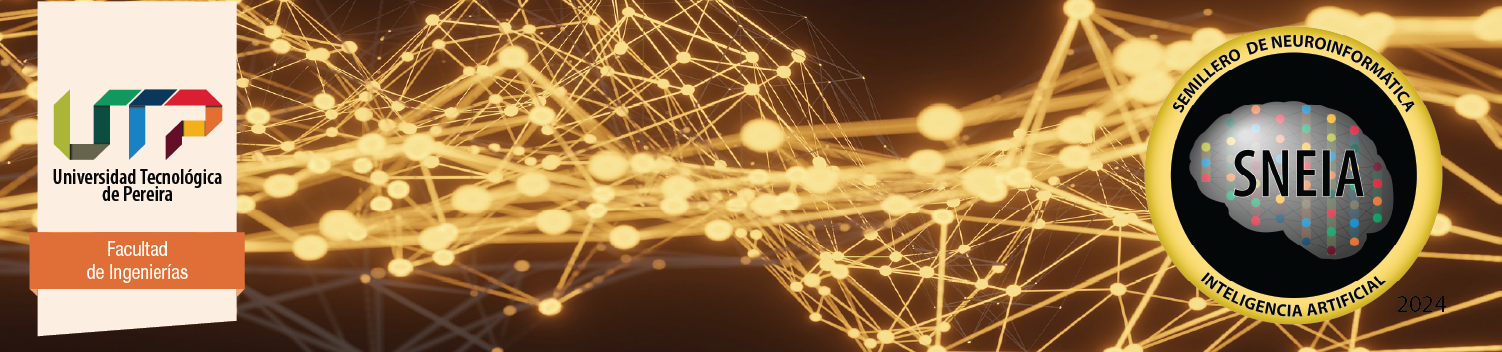

# Redes convolucionales
En este notebook vamos a trabajar con redes convolucionales. Las redes convolucionales utilizan la información morfológica de las imágenes para realizar sus tareas. Esta información se obtiene mediante una serie de procesos de filtrado a través de unas unidades llamadas *Kernels*. \\
Los *Kernels* realizan un proceso llamado convolución, este proceso se puede entender como un proceso de filtrado a la imagen. \\
Mediante los procesos de filtrado se pueden extraer bordes, identificar lineas en diversas orientaciones, difuminar, aumentar contraste, entre un gran número de operaciones. El desarrollador no debe preocuparse por cuál tipo de *Kernel* usar, ya que es justamente esto lo que "aprende" la red, para lograr su tarea, la cuál en nuestro caso será distinguir entre gatos y perros.


Los pasos que se implementan son:

  1. Descarga de los datos
  2. Organización de los datos en carpetas
  3. Construcción del modelo
  4. Compilación del modelo
  5. Creación de los generadores de datos
  6. Entrenamiento de la red
  7. Prueba con nuevos datos

## 1. Descarga de los datos
La descarga de los datos se realiza mediante en comando *wget*. Dado que este es un comando ejecutado en el terminal, se antecede de un signo de admiración.  

In [ ]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O /tmp/cats_and_dogs_filtered.zip


--2024-09-04 01:28:38--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.207, 173.194.202.207, 173.194.203.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   230MB/s    in 0.3s    

2024-09-04 01:28:38 (230 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



## 2. Organización de los datos en carpetas
Para organizar los datos de este conjunto, debemos utilizar la libreria **zip**.
La librería zip permite manejar archivos comprimidos. Para la gestión de las carpetas utilizaremos la librería **os**.
 Esta librería permite acceder a funciones del sistema operativo, en nuestro caso, la utilizaremos para generar las variables correspondientes a las rutas donde se encuentran los datos de validación. Es de notar que este set de datos genera automáticamente las carpetas de validación y entrenamiento al momento de descomprimir el archivo.

In [ ]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# el directorio base está ubicado donde se descomprimen los datos
base_dir = '/tmp/cats_and_dogs_filtered'

#Directorios de entrenamiento y validacion
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

#Directorios con nuestras imagenes de entrenamiento de gatosy perros
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

#Directorios con nuestras imagenes de validacion de gatosy perros
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

### 2.1 Inspección de los datos
A continuación realizaremos una serie de procesos para ver la naturaleza de los datos que vamos a utilizar. Esta sección es opcional, sin embargo es importante revisar los datos cuando se están realizando procesos de machine learning.

### 2.1.1 Listado de los nombres de los archivos
Vamos a guardar los nombres de los archivos en dos listas, y vamos a visualizar los diez primeros

In [ ]:
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.224.jpg', 'cat.385.jpg', 'cat.227.jpg', 'cat.616.jpg', 'cat.99.jpg', 'cat.45.jpg', 'cat.525.jpg', 'cat.963.jpg', 'cat.371.jpg', 'cat.111.jpg']
['dog.462.jpg', 'dog.375.jpg', 'dog.461.jpg', 'dog.439.jpg', 'dog.0.jpg', 'dog.509.jpg', 'dog.204.jpg', 'dog.484.jpg', 'dog.576.jpg', 'dog.807.jpg']


### 2.1.2 Cuenta del número de imágenes disponibles
Vamos a realizar el conteo de los datos que se tienen tanto para validación como para entrenamiento

In [ ]:
print('total training cat images :', len(os.listdir(      train_cats_dir ) ))
print('total training dog images :', len(os.listdir(      train_dogs_dir ) ))

print('total validation cat images :', len(os.listdir( validation_cats_dir ) ))
print('total validation dog images :', len(os.listdir( validation_dogs_dir ) ))

total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500


### 2.1.3 Visualización de algunas imágenes
El siguiente bloque de código permite visualizar 16 imágenes de perros y gatos.

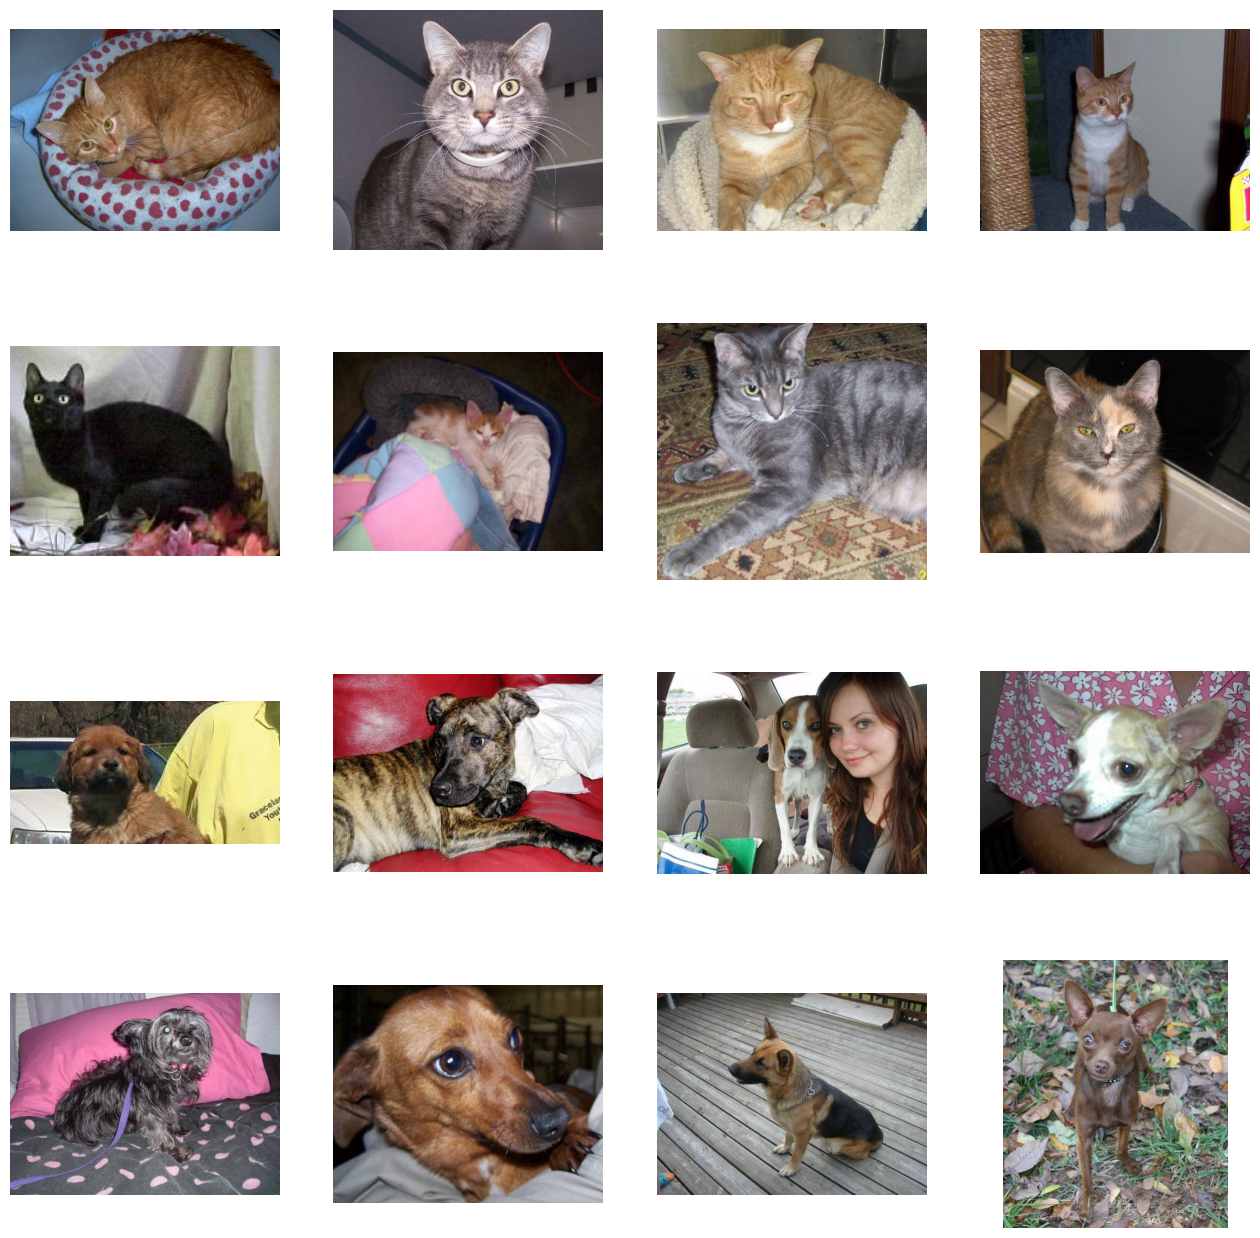

In [ ]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname)
                for fname in train_cat_fnames[ pic_index-8:pic_index]
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname)
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## 3.1 Construcción del modelo
A continuación se construye el modelo de red convolucional. La morfología que tendrá esta red es la siguiente:
  * Capa de entrada de 150 x 150 x 3 (el nùmero 3 es debido a los canales RGB).
  * Una capa de convolución con 16 kernels de 3x3 cada uno, con activación *RELU*.
  * Una capa de MaxPooling (2x2).
  * Una capa de convolución con 32 kernels de 3x3 con activación *RELU*.
  * Una capa de MaxPooling (2x2).
  * Una capa de convolución con 64 kernels de 3x3 con activación *RELU*.
  * Una capa de MaxPooling (2x2)
  * Una capa tipo *Flatten* la cuál aplana la salida de la capa anterior
  * Una capa de 512 neuronas densamente conectadas con activación RELU.
  * Una neurona para la clasificación binaria con activación *Sigmoid*

In [ ]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # Esta es la primer convolución, acá definimos que la señal de entrada sea 150x150 con 3 canales para el color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    #La segunda convolución
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #La tercera convolución
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #Flatten para alimentar la red neuronal
    tf.keras.layers.Flatten(),
    # 512 neuronas en la capa oculta
    tf.keras.layers.Dense(512, activation='relu'),
    #  Sólo una neurona de salida. Contiene un valor de 0 o 1, donde 0 es para 'cats' y 1 es para 'dogs'
    tf.keras.layers.Dense(1, activation='sigmoid')
])


### Alternativas para la definición de la red
La API de keras nos ofrece varias alternativas para definir nuestras redes. Todas son equivalentes, sin embargo, existen representaciones que pueden facilitar la construcción de redes mas complejas, con multiples arquitecturas en paralelo, o varias salidas y/o entradas. A continuación se muestran dos de las mas importantes:
### Forma alternativa número 1
```
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model

# Definir la entrada
inputs = Input(shape=(150, 150, 3))

# Primera convolución
x = Conv2D(16, (3, 3), activation='relu')(inputs)

x = MaxPooling2D((2, 2))(x)

# Segunda convolución
x = Conv2D(32, (3, 3), activation='relu')(x)

x = MaxPooling2D((2, 2))(x)

# Tercera convolución
x = Conv2D(64, (3, 3), activation='relu')(x)

x = MaxPooling2D((2, 2))(x)

# Aplanar
x = Flatten()(x)

# Capa densa
x = Dense(512, activation='relu')(x)

# Capa de salida
outputs = Dense(1, activation='sigmoid')(x)

# Crear el modelo
model = Model(inputs=inputs, outputs=outputs)

```
### Forma alternativa número 2
```
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()

# Primera convolución
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))

# Segunda convolución
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Tercera convolución
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Aplanar
model.add(Flatten())

# Capa densa
model.add(Dense(512, activation='relu'))

# Capa de salida
model.add(Dense(1, activation='sigmoid'))
```



### Sumario de la red
Es una buena práctica realizar un sumario de la red construida, o si es el caso de que estemos usando una arquitectura importada, este paso es imprescindible.


In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 18496)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       9,470,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,494,561 (36.22 MB)

 Trainable params: 9,494,561 (36.22 MB)

 Non-trainable params: 0 (0.00 B)

## 4. Compilación del modelo
A continuación realizamos la compilación del modelo. En este paso se define el optimizador a utilizar, su tasa de aprendizaje, su función de perdida y la métrica con la que evaluaremos su desempeño.

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

## 5. Creación de los generadores de datos
Los generadores de datos son una de las características mas poderosas de la librería Keras. Los generadores de datos se ocupan de los procesos para gestionar el flujo de imagenes desde las carpetas donde se encuentran las imágenes, hacia el modelo para ser utilizadas por este. Dentro de sus funciones esta la de hacer procesos sobre la marcha, tales como escalar, determinar el número de imágenes que se cargan al tiempo para así gestionar razonablemente recursos de memoria, así como modificar el tamaño de las imágenes para que se ajusten al tamaño que recibe el modelo.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Crear un generador de imágenes con reescalamiento
# Todas las imagenes serán reescaladas por 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Cargamos la imagenes directamente desde un directorio estructurado
# donde cada directorio representa una clase
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,    # rutas a los directorios
                                                    batch_size=20,  # tamaño de los lotes de datos a generar
                                                    class_mode='binary',  # tipo de etiqueta que se retornara (ejm: 'categorical')
                                                    target_size=(150, 150)) # tamaño al cual se redimensionaran las imagenes

validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## 6. Entrenamiento de la red
A continuación damos inicio al entrenamiento de la red. En este punto definimos los conjuntos de entrenamiento y de validación para que correspondan a los generadores de datos previamente definidos. Se define el número de epocas y el numero de pasos de validación.

In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    validation_steps=10,
)

Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.4787 - loss: 0.8472 - val_accuracy: 0.5100 - val_loss: 0.6889
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.5869 - loss: 0.6742 - val_accuracy: 0.5800 - val_loss: 0.6405
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.6623 - loss: 0.6134 - val_accuracy: 0.7000 - val_loss: 0.6012
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.7198 - loss: 0.5635 - val_accuracy: 0.6700 - val_loss: 0.5822
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7653 - loss: 0.4791 - val_accuracy: 0.7050 - val_loss: 0.5733


## Prueba con nuevos datos
El siguiente script permite subir imagenes desde nuestra computadora hacia el modelo, y así obtener una predicción de esta.

In [ ]:
import numpy as np

from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():

  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(150, 150))

  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size=10)

#prueba
  score = model.evaluate(images,np.ndarray(1), verbose=1)
  print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

# prueba

  print(classes[0])

  if classes[0]>0:
    print(fn + " is a dog")

  else:
    print(fn + " is a cat")

Saving european-shorthair-8601492_1280.jpg to european-shorthair-8601492_1280.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0000e+00 - loss: 85.9427
Test loss: 85.9427490234375 / Test accuracy: 0.0
[1.]
european-shorthair-8601492_1280.jpg is a dog
